While the use of Spectral Whitening did not lead to AUC improvments in my models I decided to document share this as experiments that fail are still valuable for the leassons that were learnt. 

## Spectral Whitening

In reviewing the examples given in [GWPy](https://gwpy.github.io/docs/stable/examples/spectrogram/spectrogram2.html) I noticed the use of a technique called "spectral wightening" that was central to detecting the GW signal in the noice. Based on this work I decided to try:
1. Standardizing each signal, i.e., dividing by the max value of the signal.
2. Apply spectral whitening
3. Convert that to a spectrogram
4. Train a CNN to recognise the "chirp"

To implement this I made the following choices:
* For the CNN I used a pre-trained EfficientNet. To make this easier to code I used Keras
* I first tried to use the spectrogram code in GWPy however I found that nnAudio ran about 100x faster, so like many other I switched to using nnAudio to create the spectrogram on the fly.
* I tried to use the GWPy whitening function but this was too slow. As I could not find a whitening function in nnAudio or other PyTorch modules I wrote my own. First I had to understand what whitening was, then I had to code for it.


I then ran this, using EffficientNetB3, and found that whitening the signal gave a 10% lower AUC.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# What a real GW event looks like
Loosely following the example in [GWPy](https://gwpy.github.io/docs/stable/examples/spectrogram/spectrogram2.html) I read in a 2sec sample with known Gravity Wave event and create two spectrograms. 
1. The first, without whitening, the GW "chirp" can't be seen with the eye.
2. The second, with whitening, clearly showsthe "chip" at the 0.4s mark starting at a low frequency (~30hx) and ramping up (~200hz) few hundrets of a second.
 
Looking at how different these were I wondered if whitening could be used to improve my CNN model?

In [30]:
train_labels = pd.read_csv("./g2net-gravitational-wave-detection/training_labels_with_paths.csv")
train_labels.target.value_counts()

def correct(row):
    return row["filepath"].replace("/kaggle/input", ".")

train_labels["filepath"] = train_labels.apply(correct, axis=1)

ts = TimeSeries(np.load(train_labels[train_labels.target==1].iloc[20].filepath)[0], sample_rate=2048)

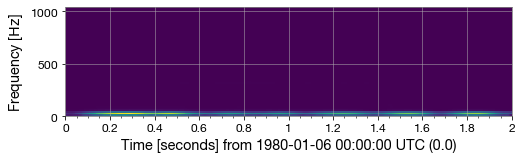

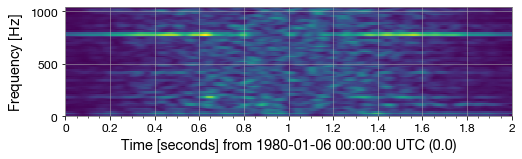

In [31]:
from gwpy.timeseries import TimeSeries
# lh = TimeSeries.fetch_open_data('H1', 1126259458+3.5, 1126259458+3.5+2,)

lh = ts

specgram = lh.spectrogram2(fftlength=1/16., overlap=15/256.) ** (1/2.)
specgram.plot(figsize=(8, 2));
plt.show()
specgram = lh.whiten(2, 1).spectrogram2(fftlength=1/16., overlap=15/256.) ** (1/2.)
specgram.plot(figsize=(8, 2));
plt.show()

## Spectral Whitening

My first thought was just to use the GWPy tools however the spectrogram was 1 - 2 orders of magnitude slower than nnAudio. I switched to nnAudio and found I could generate the spectrograms of the fly, which was very convenient. 

However, I still had the problem that GWPy whitening  too slow so I set about building my own in torch to see how much faster this was. After much reading I implemented the following algorithm.

In [32]:
import torch
from torch.fft import fft, rfft, ifft

def whiten(signal):
    hann = torch.hann_window(len(signal), periodic=True, dtype=float)
    spec = fft(torch.from_numpy(signal).float()* hann)
    mag = torch.sqrt(torch.real(spec*torch.conj(spec))) 

    return torch.real(ifft(spec/mag)).numpy() * np.sqrt(len(signal)/2)

The charts of the whitened data below show the Torch version has similar but not quite the same output as GWPy. Comparing the GWPy [code](https://github.com/gwpy/gwpy/blob/v2.0.4/gwpy/timeseries/timeseries.py#L1669), the key difference is  in the last line my algorithm use multiplication in frequency-space and GWPy uses convolution with a hann window in time-space. I think its the use of the hann window that results a slighly different envelope. 

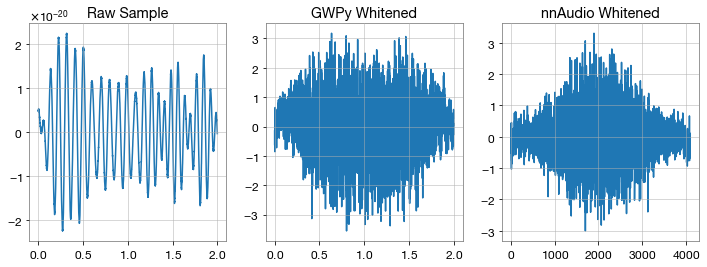

In [33]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(lh)
plt.title("Raw Sample")
plt.subplot(1, 3, 2)
plt.plot(lh.whiten(2,1))
plt.title("GWPy Whitened")
plt.subplot(1, 3, 3)
plt.title("nnAudio Whitened")
plt.plot(whiten(lh.value))
plt.show()

What is most notable is the PYtorch is about 10x faster when using a CPU 

In [34]:
%timeit lh.whiten(2,0)
%timeit whiten(lh.value)

9.84 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
297 µs ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Comparing Spectrogram
To show that the new torch function works just as well, I create spectrograms of teh whitened sample using GWPy vs nnAudio/Torch

In [35]:
from nnAudio.Spectrogram import CQT1992v2
def qgram(ts, 
           transform=CQT1992v2(sr=2048, fmin=20, fmax=2048/2, hop_length=64)): # tweak parameters to make a 64x64 image
    image = transform(torch.from_numpy(ts).float()) # returns a tensor of spectrograms of shape = (num_samples, freq_bins,time_steps)
    image = image.squeeze().numpy()

    return image

CQT kernels created, time used = 0.0173 seconds


/usr/local/anaconda3/envs/GravWave/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


Again why not identical, we can see the tell tail signal of the 'chirp' in the spectrogram. However, when I used whitening in my modeling I found the AUC was substatially worse.

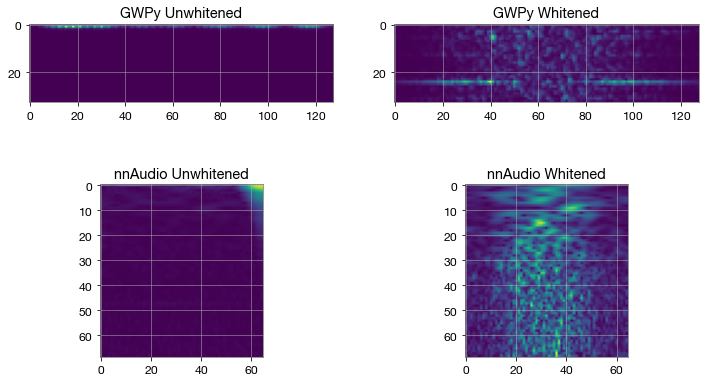

In [36]:
plt.figure(figsize=(12,7))
plt.subplot(2,2,1)
plt.imshow(lh.spectrogram2(fftlength=1/32., overlap=1/32-1/64))
plt.title("GWPy Unwhitened")

plt.subplot(2,2,2)
plt.imshow(lh.whiten(2,1).spectrogram2(fftlength=1/32., overlap=1/32-1/64.))
plt.title("GWPy Whitened")

plt.subplot(2,2,3)
plt.imshow(qgram(lh))
plt.title("nnAudio Unwhitened")

plt.subplot(2,2,4)
plt.imshow(qgram(whiten(lh)))
plt.title("nnAudio Whitened")
plt.show()

# Competition Data
The million dollar question is does this reveal the "chirp" signture for he competition data. 

In the plots below we use the GWPy code, with the first column being the unwhitened spectrogram and the second whitened, but we don't get a dramatic result as we did with the real GW data.  Note the firs tthree are target =1 and the second three target =0

In [8]:
train_labels = pd.read_csv('../input/g2net-gravitational-wave-detection/training_labels.csv')
sample_submission = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')

def id2path(idx,is_train=True):
    path = "../input/g2net-gravitational-wave-detection"
    folder = 'train' if is_train else 'test'
    return f'{path}/{folder}/{idx[0]}/{idx[1]}/{idx[2]}/{idx}.npy'

FileNotFoundError: [Errno 2] No such file or directory: '../input/g2net-gravitational-wave-detection/training_labels.csv'

In [ ]:
idLst1 = train_labels[train_labels.target == 1].sample(3).values.tolist()
idLst0 = train_labels[train_labels.target == 0].sample(3).values.tolist()

for _id, target in idLst1+idLst0:
    wave = np.load(id2path(_id,is_train=True))[0]
    ts  = TimeSeries(wave, sample_rate=2048)
    plt.figure(figsize=(14, 5))
    
    plt.subplot(131)
    plt.imshow(ts.spectrogram2(fftlength=1/32., overlap=1/32-1/64.))
    plt.title(f"Tgt={target} raw")

    plt.subplot(132)
    plt.imshow(ts.whiten().spectrogram2(fftlength=1/32., overlap=1/32-1/64.))
    plt.title("Whiten")